In [1]:
## Import necessary libraries
import pandas as pd
from thefuzz import process
import matplotlib.pyplot as plt

In [2]:
## Load the dataset
df = pd.read_csv('../Datasets/Retail Sales/raw/Sales_Data_2023_2025.csv')

In [3]:
## inspect dataset
# display(df.head())
print(df.info())
# print(df.describe())

<class 'pandas.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   transactions_id  5000 non-null   str    
 1   sale_date        5000 non-null   str    
 2   sale_time        5000 non-null   str    
 3   customer_id      5000 non-null   int64  
 4   product_id       4948 non-null   float64
 5   product          4945 non-null   str    
 6   category_id      4960 non-null   float64
 7   category         4944 non-null   str    
 8   quantity         4904 non-null   float64
 9   price_per_unit   5000 non-null   float64
 10  total_sale       4705 non-null   float64
dtypes: float64(5), int64(1), str(5)
memory usage: 429.8 KB
None


In [4]:
## Count missing values in each column
print(df.isnull().sum())

transactions_id      0
sale_date            0
sale_time            0
customer_id          0
product_id          52
product             55
category_id         40
category            56
quantity            96
price_per_unit       0
total_sale         295
dtype: int64


In [5]:
# Returns rows where 'transactions_id' doesn't start with a digit (0-9)
print(df[df['transactions_id'].str.contains(r'^[^0-9]')])

     transactions_id       sale_date   sale_time  customer_id  product_id  \
6             TX-590      2024-01-12     0:55:50          164       103.0   
354          TX-4828      15/08/2023     1:49:50          101       303.0   
422          TX-2373       08-Nov-25    12.34.55          258       301.0   
452          TX-4416    31/01/2023         16:04          198       301.0   
717           TX-568      12/01/2025     5:07:46          263       202.0   
734          TX-4846       23-Jun-25    16.45.58          148       401.0   
897          TX-3376      2025-09-30    12.24.20          137       202.0   
1480         TX-4513      12/29/2023       18:20          259       401.0   
1510         TX-1766     11/08/2024         6:37          166       302.0   
1538         TX-3297      03/10/2025    19.34.28          261       102.0   
2031         TX-3596      2024-01-23    21:44:30          205       202.0   
2133          TX-986      05/21/2024       18:41          141       401.0   

In [6]:
# Remove all non-digit characters from the begiining of the 'transactions_id' column
df['transactions_id'] = df['transactions_id'].str.replace(r'^\D+', '', regex=True)

In [7]:
print(df['sale_date'].head(10))

0        02-Aug-23
1        16-Dec-25
2        17-Nov-23
3        14-May-25
4      2023/10/06 
5       09/28/2023
6       2024-01-12
7       2024-11-03
8       24/11/2025
9       09/04/2025
Name: sale_date, dtype: str


In [8]:
## Remove all leading and trailing whitespace from 'sale_date' column
df['sale_date'] = df['sale_date'].str.strip()

In [9]:
## Parse/standardize sale_date column
df['sale_date'] = pd.to_datetime(df['sale_date'], format='mixed', errors='coerce').dt.strftime("%Y-%m-%d")

In [10]:
print(df['sale_time'].head(10))

0     21:32:42
1     10.32.35
2     03.44.23
3     05.58.09
4    08.54.55 
5     20:19:10
6      0:55:50
7        20:21
8        19:33
9        18:17
Name: sale_time, dtype: str


In [11]:
## Remove all leading and trailing whitespace from 'sale_time' column
df['sale_time'] = df['sale_time'].str.strip()

In [12]:
df['sale_time'] = df['sale_time'].str.replace(r'[^\d]', ':', regex=True)

In [13]:
## Parse/standardize time column
df['sale_time'] = pd.to_datetime(df['sale_time'], format='mixed', errors='coerce').dt.strftime('%H:%M:%S')

In [14]:
## Remove all leading and trailing whitespace from 'category' and captialize each word
df['category'] = df['category'].str.strip().str.title()

In [15]:
## Retrieve list of unique categories names
print(df['category'].unique())

<StringArray>
[    'Grocery', 'Electronics',  'Stationery',   'Furniture', 'Electbonics',
  'Rtationery',  'Statiouery',   'Furnuture',           nan, 'Electvonics',
 ...
 'Electronpcs',  'Stationefy',     'Grorery',  'Stafionery',  'Statiogery',
   'Furniturv',   'Jurniture', 'Electronecs',  'Stationtry', 'Eyectronics']
Length: 371, dtype: str


In [16]:
df['category'] = df['category'].replace('.*(Furni|ture).*', 'Furniture', regex=True)
df['category'] = df['category'].replace('.*(Elec|Electr|tronics).*', 'Electronics', regex=True)
df['category'] = df['category'].replace('.*(Stati|onery).*', 'Stationery', regex=True)
df['category'] = df['category'].replace('.*(Gro|cery).*', 'Grocery', regex=True)

In [17]:
# Create a mapping of ID to Category & vice versa
mapping_id = {1: 'Electronics', 2: 'Furniture', 3: 'Stationery', 4: 'Grocery'}
mapping_cat = {'Electronics': 1, 'Furniture': 2, 'Stationery': 3, 'Grocery': 4}

In [18]:
# Map the IDs to the category column & populate the NaN values
df['category'] = df['category'].fillna(df['category_id'].map(mapping_id))

In [19]:
# Map the Category to the ID column & populate the NaN values
df['category_id'] = df['category_id'].fillna(df['category'].map(mapping_cat))

In [20]:
display(df[df['category_id'].isna()])

,transactions_id,sale_date,sale_time,customer_id,product_id,product,category_id,category,quantity,price_per_unit,total_sale
2329,3789,2025-03-09,09:14:35,214,401.0,Coffee Beans 1kg,NaN,NaN,2.0,19.99,39.98


In [21]:
df['category_id'] = df['category_id'].fillna(0)

In [22]:
# Convert Category Id column from float to integer
df['category_id'] = df['category_id'].astype(int)

In [23]:
# Create category dataframe with only the Id and Category columns, dropping NaNs and duplicates
df_category = df[['category_id', 'category']].dropna().drop_duplicates().reset_index(drop=True)

In [24]:
df_category.to_csv('../Datasets/Retail Sales/cleaned/Category_Cleaned.csv', index=False)

In [25]:
## Remove all leading and trailing whitespace from 'product' and captialize each word
df['product'] = df['product'].str.strip().str.title()

In [26]:
## Fill missing product values with 'Unknown'
df['product'] = df['product'].fillna('Unknown')

In [27]:
## Retrieve list of unique product names
print(df['product'].unique().tolist())

['Ciffee Beans 1Kg', 'Mechanical Kdyboard', 'Mechanicalqkeyboard', 'Mechanical Keyboard', 'Unknown', 'Standinc Desk', 'Usb-C Cable', 'Standing Desk', 'Highlighter Set', 'Office Chair', 'Coffee Beans 1Kg', 'Ballpoint Pen', 'Green Tea Box', 'Wireless Mouse', 'Notebook A5', 'Highlightyr Set', 'Mecmanical Keyboard', 'Wireltss Mouse', 'Gffice Chair', 'Coffeeobeans 1Kg', 'Wirelessumouse', 'Mecjanical Keyboard', 'Wirelesa Mouse', 'Office Chtir', 'Standtng Desk', 'Seanding Desk', 'Office Thair', 'Office Chwir', 'Noteboox A5', 'Kighlighter Set', 'Ballpoint Pcn', 'Witeless Mouse', 'Ballpoint Ien', 'Wirelesk Mouse', 'Wiroless Mouse', 'Notebooksa5', 'Ballpoiyt Pen', 'Nitebook A5', 'Graen Tea Box', 'Office Phair', 'Xtanding Desk', 'Mechanical Keyboaro', 'Coffce Beans 1Kg', 'Highlighter Slt', 'Standing Desl', 'Green Tea Bvx', 'Highlighrer Set', 'Usb-C Caele', 'Yechanical Keyboard', 'Office Chgir', 'Notebook Ae', 'Green Teu Box', 'Mechanical Eeyboard', 'Coffee Beans 1Rg', 'Ballpoint Pel', 'Highlikhte

In [28]:
product_corrections = ['Coffee Beans 1Kg', 'Mechanical Keyboard', 'Office Chair', 'Standing Desk', 'USB-C Cable', 'Highlighter Set', 'Notebook A5', 
                       'Ballpoint Pen', 'Green Tea Box', 'Wireless Mouse']

def get_match(row):
    # Returns (best_match, score)
    match, score = process.extractOne(row, product_corrections)
    return match if score > 85 else row

df['product'] = df['product'].apply(get_match)

In [29]:
# Create Product to ID mapping
prod_id_map = {'Coffee Beans 1Kg': 401, 'Mechanical Keyboard': 102, 'Standing Desk': 202, 'USB-C Cable': 103, 'Highlighter Set': 303, 'Office Chair': 201, 'Ballpoint Pen': 302, 
               'Green Tea Box': 402, 'Wireless Mouse': 101, 'Notebook A5': 301}

In [30]:
# Map the product to the product Id & replace/populate the NaN values in the product Id column
df['product_id'] = df['product_id'].fillna(df['product'].map(prod_id_map))

In [31]:
# Convert the Product Id column from float to integer
df['product_id'] = df['product_id'].astype(int)

In [32]:
# Create dataframe of product IDs and names
df_product = df[['product_id', 'product']].dropna().drop_duplicates().reset_index(drop=True)

In [33]:
# Drop all rows which contain 'Unknown' in the product name
df_product = df_product[~df_product['product'].str.contains('Unknown', na=False)]

In [34]:
df_product.to_csv('../Datasets/Retail Sales/cleaned/Products_Cleaned.csv', index=False)

In [35]:
# Drop rows where 'quantity' and 'total_sale' columns are both NaN/null.
df = df.dropna(subset=['quantity', 'total_sale'], how='all')

In [36]:
# Convert the Quantity values from float to integer
df['quantity'] = df['quantity'].astype(int) 

In [37]:
df['total_sale'] = df['total_sale'].fillna(df['quantity'] * df['price_per_unit']).round(2)

In [38]:
df['sale_date'] = pd.to_datetime(df['sale_date'])

In [39]:
# Monthly Sales Analysis
monthly_sales = df.groupby(df['sale_date'].dt.to_period('M'))['total_sale'].sum()

In [40]:
print(monthly_sales)

sale_date
2023-01    14421.92
2023-02     8979.52
2023-03    13862.52
2023-04    15368.20
2023-05    16199.41
2023-06    14331.23
2023-07    15522.65
2023-08    16968.95
2023-09    14314.46
2023-10    13905.62
2023-11    12857.74
2023-12    14978.53
2024-01    11383.66
2024-02    12809.13
2024-03    13663.20
2024-04    12291.17
2024-05    11745.93
2024-06    17601.52
2024-07    10810.55
2024-08    14003.97
2024-09    12784.24
2024-10    14200.94
2024-11    13948.33
2024-12    16930.91
2025-01     9681.58
2025-02    12019.36
2025-03    17193.00
2025-04    13509.09
2025-05    11869.12
2025-06    10718.94
2025-07    16930.51
2025-08    12363.55
2025-09    15242.81
2025-10    11206.06
2025-11    12136.64
2025-12    16074.48
Freq: M, Name: total_sale, dtype: float64


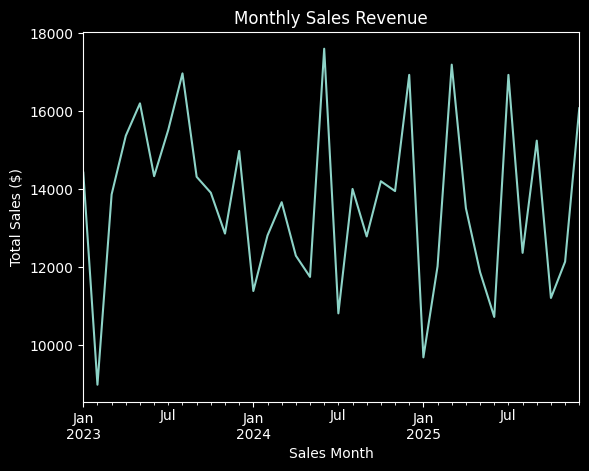

In [41]:
monthly_sales.plot(kind='line')
plt.title('Monthly Sales Revenue')
plt.xlabel('Sales Month')
plt.ylabel('Total Sales ($)')

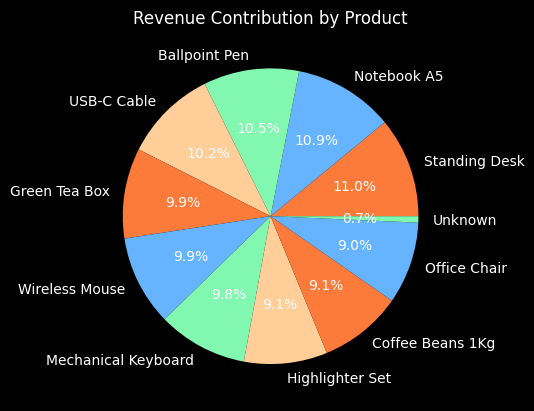

In [42]:
# Product Revenue Contribution
category_perf = df.groupby('product')['total_sale'].sum().sort_values(ascending=False)

category_perf.plot(kind='pie', autopct='%1.1f%%', colors=['#fc7b3a','#66b3ff','#81f7b0','#ffce99'])
plt.title('Revenue Contribution by Product')

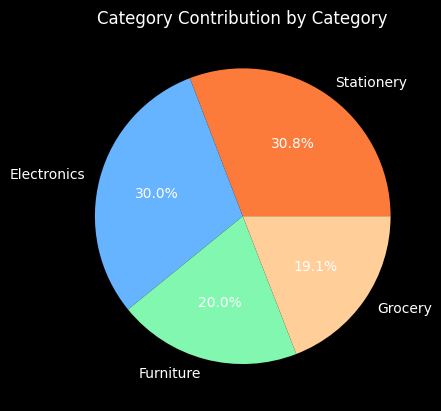

In [43]:
# Category Revenue Contribution
category_perf = df.groupby('category')['total_sale'].sum().sort_values(ascending=False)

category_perf.plot(kind='pie', autopct='%1.1f%%', colors=['#fc7b3a','#66b3ff','#81f7b0','#ffce99'])
plt.title('Category Contribution by Category')

In [44]:
## Top 10 customers by Revenue
top_10_customers = df.groupby('customer_id')['total_sale'].sum().sort_values(ascending=False).head(10)

In [45]:
print("\nTop 10 Customers by Revenue:")
print(top_10_customers)


Top 10 Customers by Revenue:
customer_id
125    9213.52
297    6385.82
183    5441.39
199    5268.44
227    5251.40
142    5211.37
196    4830.97
271    4751.51
221    4556.71
203    4491.33
Name: total_sale, dtype: float64


In [46]:
df.drop(columns=['product', 'category'], inplace=True)

In [47]:
## Create CSV file with clean dataset
df.to_csv('../Datasets/Retail Sales/cleaned/Retail_Sales_Cleaned.csv', index=False)